
# MobileNetV2 — FER2013 (Fresh Training, Overfitting-Resistant)

This notebook is a **clean, independent training pipeline** for FER-2013 images preprocessed to **224×224×3 JPEGs**.  
It **does not** depend on any previous notebooks or outputs.

**What you get:**
- Strong tf.data pipeline with effective data augmentation
- Warm-up + controlled fine-tuning (only last 12–15 layers)
- Regularization (Dropout + L2)
- History saving, plots, and test set evaluation
- Optional class weights calculation



## Imports & Configuration

In [1]:

import os
import math
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Reproducibility (best-effort; GPU nondeterminism may remain)
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Paths
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"        
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
PLOTS_DIR = REPORTS_DIR / "plots"

for p in [MODELS_DIR, REPORTS_DIR, PLOTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)


IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5 

In [ ]:
DATA_DIR = Path(r"C:\Users\heshm\Documents\GitHub\Music_Recommendation_System\data\processed\FC211042_Heshani")
index_path = DATA_DIR / "index.csv"
df = pd.read_csv(index_path)

# Ensure required columns
assert {"path", "label", "split"} <= set(df.columns)
df["path"] = df["path"].apply(lambda p: str(Path(p).resolve()))

# ====== FIX: label encoding comes *before* splitting ======
label2id = {label: idx for idx, label in enumerate(sorted(df["label"].unique()))}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["label"].map(label2id).astype("int64")
print("Label mapping:", label2id)

# Now split after labels are numeric
train_df = df[df["split"] == "train"].copy()
val_df   = df[df["split"] == "val"].copy()
test_df  = df[df["split"] == "test"].copy()

print("Counts:")
for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"  {name:5s}: {len(d):6d}")
print("\nClass distribution (train):")
print(train_df["label"].value_counts().sort_index())



Label mapping: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}
Counts:
  Train:  21758
  Val  :   2418
  Test :   6043

Class distribution (train):
label
0    3596
1    6493
2    4468
3    4347
4    2854
Name: count, dtype: int64


In [ ]:
from collections import Counter

def compute_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())
    weights = {}
    for c in range(num_classes):
        # classic inverse frequency
        freq = counts.get(c, 0) / total
        weights[c] = 0.0 if freq == 0 else (1.0 / (num_classes * freq))
    return weights

use_class_weights = True
class_weights = compute_class_weights(train_df["label"].tolist(), NUM_CLASSES) if use_class_weights else None
print("Class weights:", class_weights)


Class weights: {0: 1.2101223581757508, 1: 0.6701986754966888, 2: 0.9739480752014325, 3: 1.0010582010582012, 4: 1.5247372109320252}


In [ ]:
def decode_and_preprocess(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label


def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_crop(
        tf.image.resize_with_crop_or_pad(img, IMG_SIZE + 8, IMG_SIZE + 8),
        [IMG_SIZE, IMG_SIZE, 3]
    )
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_saturation(img, 0.9, 1.1)
    return img, label


label2id = {label: idx for idx, label in enumerate(sorted(df["label"].unique()))}
print("Label mapping:", label2id)

df["label"] = df["label"].map(label2id)


def make_ds(frame, training=False, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((frame["path"].values, frame["label"].values))
    if training:
        ds = ds.shuffle(min(len(frame), 8192), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df, training=False)
test_ds  = make_ds(test_df, training=False)

label2id = {label: idx for idx, label in enumerate(sorted(df["label"].unique()))}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df["label"].map(label2id).astype("int64")

print("Label mapping:", label2id)
print(df.head())


Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}
Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}
   split  label                                               path
0  train      1  C:\Users\heshm\Documents\GitHub\Music_Recommen...
1  train      0  C:\Users\heshm\Documents\GitHub\Music_Recommen...
2  train      1  C:\Users\heshm\Documents\GitHub\Music_Recommen...
3  train      1  C:\Users\heshm\Documents\GitHub\Music_Recommen...
4  train      2  C:\Users\heshm\Documents\GitHub\Music_Recommen...


# Build model

In [6]:

# ============================================================
# Build Model
# ============================================================
def build_model(img_size=224, num_classes=5, dropout=0.5, l2w=5e-5, alpha=1.0):
    base = keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights="imagenet",
        alpha=alpha
    )
    base.trainable = False

    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax",
                           kernel_regularizer=regularizers.l2(l2w))(x)
    return keras.Model(inputs, outputs)

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Phase 1 — Warm-up

In [ ]:
warmup_ckpt = MODELS_DIR / "mobilenetv2_warmup.keras"

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_warm = [
    keras.callbacks.ModelCheckpoint(str(warmup_ckpt), monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
]

hist_warm = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_warm,
    class_weight=(class_weights if use_class_weights else None),
    verbose=1
)


Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.3375 - loss: 1.7202
Epoch 1: val_loss improved from None to 1.18979, saving model to models\mobilenetv2_warmup.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 276s 397ms/step - accuracy: 0.3994 - loss: 1.5195 - val_accuracy: 0.5269 - val_loss: 1.1898 - learning_rate: 0.0010
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4650 - loss: 1.3212
Epoch 2: val_loss improved from 1.18979 to 1.18072, saving model to models\mobilenetv2_warmup.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 265s 389ms/step - accuracy: 0.4671 - loss: 1.3124 - val_accuracy: 0.5335 - val_loss: 1.1807 - learning_rate: 0.0010
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4803 - loss: 1.2823
Epoch 3: val_loss did not improve from 1.18072
680/680 ━━━━━━━━━━━━━━━━━━━━ 264s 388ms/step - accuracy: 0.4810 - loss: 1.2875 - val_accuracy: 0.5331 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - a

In [ ]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Phase 1 — Warm-up (head only or shallow unfreeze)
# ----------------------------
warmup_ckpt_best = MODELS_DIR / "mobilenetv2_warmup_best_valacc.keras"
warmup_ckpt_all  = MODELS_DIR / "warm_ckpt-epoch{epoch:02d}.weights.h5"

# Compile (higher LR)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_warm = [
    # Select by val_accuracy for warmup
    keras.callbacks.ModelCheckpoint(
        filepath=str(warmup_ckpt_best),
        monitor="val_accuracy", mode="max",
        save_best_only=True, verbose=1
    ),
    # Save every epoch (for later inspection)
    keras.callbacks.ModelCheckpoint(
        filepath=str(warmup_ckpt_all),
        save_weights_only=True, save_best_only=False, verbose=0
    ),
    # Smooth LR on plateau using loss (less noisy than acc)
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max",
        patience=3, restore_best_weights=True, verbose=1
    ),
]

hist_warm = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_warm,
    class_weight=(class_weights if use_class_weights else None),
    verbose=1
)

# Track best warmup epoch by val_accuracy
best_warm_ep = 1 + int(np.argmax(hist_warm.history["val_accuracy"]))
best_warm_acc = float(hist_warm.history["val_accuracy"][best_warm_ep-1])
print(f"[Warmup] Best epoch by val_accuracy: {best_warm_ep} | val_acc={best_warm_acc:.4f}")



Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.3396 - loss: 1.6870
Epoch 1: val_accuracy improved from None to 0.50496, saving model to models\mobilenetv2_warmup_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 302s 436ms/step - accuracy: 0.3994 - loss: 1.5055 - val_accuracy: 0.5050 - val_loss: 1.2174 - learning_rate: 0.0010
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.4656 - loss: 1.3338
Epoch 2: val_accuracy improved from 0.50496 to 0.51737, saving model to models\mobilenetv2_warmup_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 295s 434ms/step - accuracy: 0.4701 - loss: 1.3186 - val_accuracy: 0.5174 - val_loss: 1.1878 - learning_rate: 0.0010
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.4821 - loss: 1.2790
Epoch 3: val_accuracy improved from 0.51737 to 0.52605, saving model to models\mobilenetv2_warmup_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 280s 371ms/step - accuracy: 0.4843 - loss: 1.2818 - val_accuracy: 0.5261

In [7]:
# ----------------------------
# Phase 2 — Fine-tuning (unfreeze last N layers)
# ----------------------------
finetuned_ckpt_best = MODELS_DIR / "mobilenetv2_finetuned_best_valacc.keras"
finetuned_ckpt_all  = MODELS_DIR / "fine_ckpt-epoch{epoch:02d}.weights.h5"

# Unfreeze last 12 layers of the base model
base_model = model.layers[1]  # assumes model = [Input, BaseModel, GAP, Dropout, Dense...]
base_model.trainable = True
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= len(base_model.layers) - 12)

# Re-compile with lower LR for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_fine = [
    # Select by val_accuracy (this is the one that decides "best epoch")
    keras.callbacks.ModelCheckpoint(
        filepath=str(finetuned_ckpt_best),
        monitor="val_accuracy", mode="max",
        save_best_only=True, verbose=1
    ),
    # Also keep every epoch's weights
    keras.callbacks.ModelCheckpoint(
        filepath=str(finetuned_ckpt_all),
        save_weights_only=True, save_best_only=False, verbose=0
    ),
    # Keep LR scheduling on loss (more stable)
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max",
        patience=5, restore_best_weights=True, verbose=1
    ),
]

hist_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,   # you can use 20–30; ES will stop early
    callbacks=callbacks_fine,
    class_weight=(class_weights if use_class_weights else None),
    verbose=1
)

# Report best fine-tune epoch by val_accuracy
best_fine_ep = 1 + int(np.argmax(hist_fine.history["val_accuracy"]))
best_fine_acc = float(hist_fine.history["val_accuracy"][best_fine_ep-1])
best_fine_loss = float(hist_fine.history["val_loss"][best_fine_ep-1])
print(f"[Finetune] Best epoch by val_accuracy: {best_fine_ep} | "
      f"val_acc={best_fine_acc:.4f} | val_loss={best_fine_loss:.4f}")

# Load the best-accuracy fine-tuned model (for deployment/eval later)
best_model = tf.keras.models.load_model(str(finetuned_ckpt_best))

Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4429 - loss: 1.4011
Epoch 1: val_accuracy improved from None to 0.33664, saving model to models\mobilenetv2_finetuned_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 335s 483ms/step - accuracy: 0.5133 - loss: 1.2295 - val_accuracy: 0.3366 - val_loss: 2.8070 - learning_rate: 1.0000e-04
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6059 - loss: 1.0128
Epoch 2: val_accuracy improved from 0.33664 to 0.49586, saving model to models\mobilenetv2_finetuned_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 324s 475ms/step - accuracy: 0.6148 - loss: 0.9943 - val_accuracy: 0.4959 - val_loss: 1.6835 - learning_rate: 1.0000e-04
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6443 - loss: 0.9252
Epoch 3: val_accuracy improved from 0.49586 to 0.59884, saving model to models\mobilenetv2_finetuned_best_valacc.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 338s 497ms/step - accuracy: 0.6513 - loss: 0.9112 - val

Saved final model to: models\mobilenetv2_final_2.keras
Saved history to: reports\history_2.csv


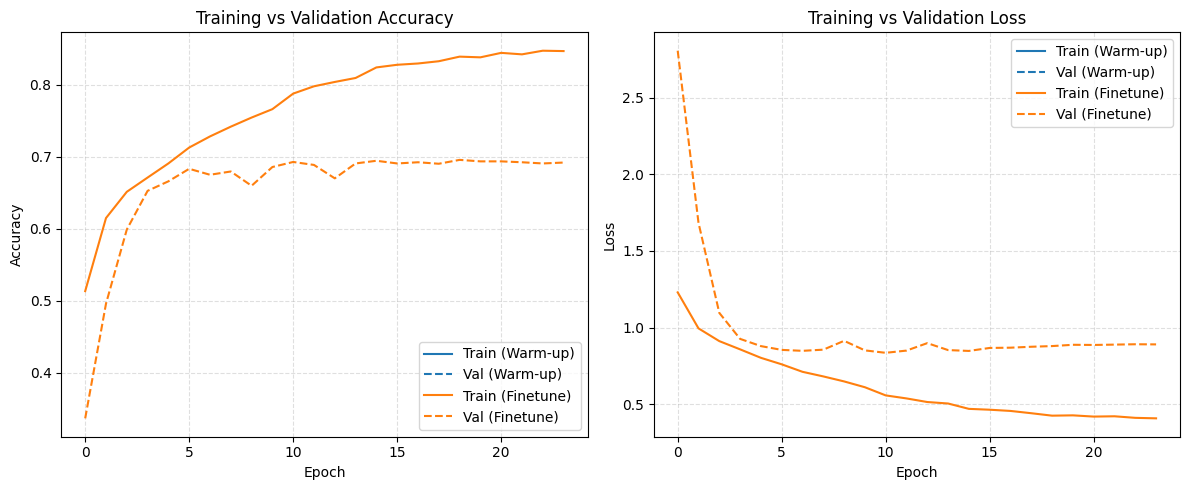

Saved combined accuracy/loss plot to: reports\plots\accuracy_loss_phases.png


In [8]:


final_model_path = MODELS_DIR / "mobilenetv2_final_2.keras"
model.save(final_model_path)
print("Saved final model to:", final_model_path)

hist = pd.DataFrame()
if 'hist_warm' in globals():
    hist = pd.concat([hist, pd.DataFrame(hist_warm.history).assign(phase="warmup")], ignore_index=True)
if 'hist_fine' in globals():
    hist = pd.concat([hist, pd.DataFrame(hist_fine.history).assign(phase="finetune")], ignore_index=True)

hist_path = REPORTS_DIR / "history_2.csv"
hist.to_csv(hist_path, index=False)
print("Saved history to:", hist_path)

# ============================================================
# Plot nicely organized curves
# ============================================================
if not hist.empty:
    plt.figure(figsize=(12, 5))
    
    # -------- Left: Accuracy --------
    plt.subplot(1, 2, 1)
    plt.plot(hist[hist.phase == "warmup"]["accuracy"].reset_index(drop=True), label="Train (Warm-up)", color="#1f77b4")
    plt.plot(hist[hist.phase == "warmup"]["val_accuracy"].reset_index(drop=True), label="Val (Warm-up)", linestyle="--", color="#1f77b4")
    
    if "finetune" in hist.phase.unique():
        plt.plot(hist[hist.phase == "finetune"]["accuracy"].reset_index(drop=True), label="Train (Finetune)", color="#ff7f0e")
        plt.plot(hist[hist.phase == "finetune"]["val_accuracy"].reset_index(drop=True), label="Val (Finetune)", linestyle="--", color="#ff7f0e")

    plt.title("Training vs Validation Accuracy", fontsize=12)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    # -------- Right: Loss --------
    plt.subplot(1, 2, 2)
    plt.plot(hist[hist.phase == "warmup"]["loss"].reset_index(drop=True), label="Train (Warm-up)", color="#1f77b4")
    plt.plot(hist[hist.phase == "warmup"]["val_loss"].reset_index(drop=True), label="Val (Warm-up)", linestyle="--", color="#1f77b4")
    
    if "finetune" in hist.phase.unique():
        plt.plot(hist[hist.phase == "finetune"]["loss"].reset_index(drop=True), label="Train (Finetune)", color="#ff7f0e")
        plt.plot(hist[hist.phase == "finetune"]["val_loss"].reset_index(drop=True), label="Val (Finetune)", linestyle="--", color="#ff7f0e")

    plt.title("Training vs Validation Loss", fontsize=12)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plot_path = PLOTS_DIR / "accuracy_loss_phases.png"
    PLOTS_DIR.mkdir(exist_ok=True, parents=True)
    plt.savefig(plot_path, dpi=120)
    plt.show()
    print("Saved combined accuracy/loss plot to:", plot_path)
else:
    print("No history found to plot.")



189/189 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.6967 - loss: 0.8669

Test Accuracy: 0.6967 | Test Loss: 0.8669

Classification Report:
              precision    recall  f1-score   support

           0     0.6143    0.5919    0.6029       958
           1     0.8391    0.8348    0.8370      1774
           2     0.6015    0.6010    0.6012      1233
           3     0.5869    0.5822    0.5845      1247
           4     0.7844    0.8363    0.8096       831

    accuracy                         0.6967      6043
   macro avg     0.6852    0.6892    0.6870      6043
weighted avg     0.6954    0.6967    0.6959      6043



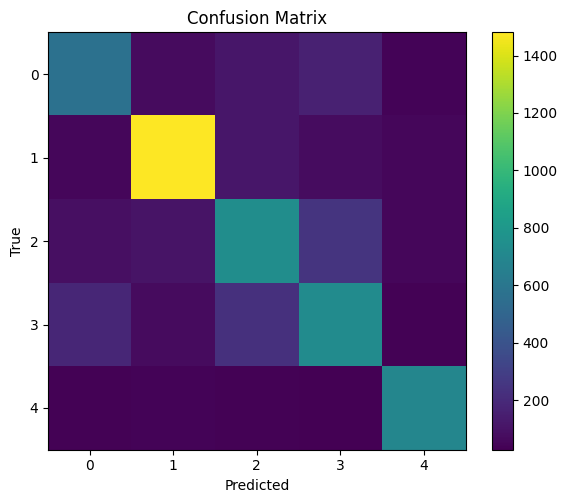

Saved confusion matrix to: reports\plots\confusion_matrix.png


In [9]:

# ============================================================
# Evaluation on Test Set + Optional Reports
# ============================================================
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Optional: Confusion matrix & classification report
try:
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt

    y_true = test_df["label"].tolist()
    probs = model.predict(test_ds, verbose=0)
    y_pred = probs.argmax(axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, list(range(NUM_CLASSES)))
    plt.yticks(tick_marks, list(range(NUM_CLASSES)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_path = REPORTS_DIR / "plots" / "confusion_matrix.png"
    plt.savefig(cm_path, dpi=120)
    plt.show()
    print("Saved confusion matrix to:", cm_path)
except Exception as e:
    print("Skipped classification report / confusion matrix:", e)
